# waypoints

## define agents

In [24]:
class FGAgent:
    def __init__(self, bubble_r=0.5, lookahead_degrees=[90., 270.], speed=2.0):
        self.bubble_r = bubble_r
        self.lookahead_degrees = lookahead_degrees
        self.speed = speed
        
    def get_action(self, state):
        ranges = state[:360]
        #print(ranges[10], ranges[90], ranges[180], ranges[270], ranges[350])
        beg = int(self.lookahead_degrees[0])
        end = int(self.lookahead_degrees[1])

        ranges = ranges[beg:end]

        ranges = np.clip(ranges, 0, 10.0)
        
        nearest_point = np.min(ranges)
        min_dist = nearest_point + self.bubble_r

        ranges = np.where(ranges <= min_dist, 0.0, ranges)

        gaps = []
        if ranges[0] != 0.0:
            gaps.append(0)

        i = 0
        while i < len(ranges):
            if ranges[i] == 0.0:
                if i > 0:
                    gaps.append(i-1)
                while i < len(ranges) and ranges[i] == 0.0:
                    i += 1
                if i < len(ranges):
                    gaps.append(i)
                continue

            i += 1

        if ranges[-1] != 0.0:
            gaps.append(len(ranges) - 1)

        assert len(gaps) % 2 == 0

        max_gap = -1
        gap_beg = 0
        gap_end = 360

        # find max gap
        i = 0
        while i < len(gaps):
            if gaps[i+1]-gaps[i] > max_gap:
                max_gap = gaps[i+1]-gaps[i]
                gap_beg = gaps[i]+beg
                gap_end = gaps[i+1]+beg
            i += 2

        mid_point = float(gap_end+gap_beg)/2.
        angle_deg = mid_point - 180
        angle_rad = angle_deg * (np.pi/180.)
#         print(f"midpoint:{mid_point}")
        angle = angle_rad * 1.0
        return [angle, self.speed]



In [40]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class WPEnv(gym.Env):
    
    def __init__(self, map_name='', begin_pos=None):
        self.map_name = map_name
        self.begin_pos = begin_pos
        self.reset()
        
  
    def reset(self):
        def render_callback(env_renderer):
            # custom extra drawing function
            
            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800
            
        map_path = f"./f1tenth_gym/examples/{self.map_name}"
        
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(render_callback)
        
        begin_pos = [0, 0, 0] if self.begin_pos is None else self.begin_pos
        obs, step_reward, done, info = self.env.reset(np.array([begin_pos]))
 
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, 10)
        buck = 3
        size = 1080//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.mean(scanner[i*buck: i*buck+buck])
                
        state = [
            agg_scanner,
            np.array(obs['linear_vels_x'][0]),
            np.array(obs['ang_vels_z'][0]),
            (obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0])
        ]

        return state
    
        
    def step(self, action):
        act = np.array([action])
        reward = 0
        obs, step_reward, done, info = self.env.step(act)
        
        if obs['collisions'][0] == 1.0:
            print("CRASHED")
            done = True
            reward = -1
        
                
        if obs['lap_counts'][0] == 1.0:
            reward = 1.0
            print("DONE")
            done = True
        
        next_state = self.to_vector_state(obs)
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

WPEnv(map_name='SILVERSTONE')

## create waypoints

In [41]:

done = False
env = WPEnv(map_name='SILVERSTONE_TRAIN3', begin_pos=[0, 0, np.pi+1])
obs = env.reset()
agent = FGAgent(speed=3.0)

positions = []

while not done:
    positions.append(obs[3])
    th, v = agent.get_action(obs[0])
    obs, r, done, _ = env.step([th, v])
#     env.render()

DONE


In [42]:
with open('ss3-wp.np', 'wb') as f:
    np.save(f, positions)

## analyze waypoints

In [3]:
import numpy as np

with open('../maps/Oschersleben1-wp.np', 'rb') as f:
    wps = np.load(f)
    
dist = np.linalg.norm(wps[0][:2] - wps[87][:2])
print(dist)
print(len(wps))
print(len(wps)//100)

1.897309351919406
8746
87


In [6]:
from tqdm import tqdm
import gym

map_name = 'Oschersleben1'
env = gym.make('f110_gym:f110-v0', map=f"../maps/{map_name}", map_ext='.png', num_agents=1)

for wp in tqdm(wps):
    obs, step_reward, done, info = env.reset(
        np.array([
            wp
        ])
    )
    if min(obs['scans'][0]) < 0.3:
        print(min(obs['scans'][0]))
        

 16%|█▌        | 1411/8746 [00:00<00:03, 2393.73it/s]

0.28378217278180073


 24%|██▍       | 2124/8746 [00:00<00:02, 2322.65it/s]

0.2896968433427534
0.276478201476305


100%|██████████| 8746/8746 [00:03<00:00, 2317.92it/s]


In [7]:
from scipy.spatial.distance import cdist

x = cdist([[0,0]], wps[:,:2])
np.argmin(x)

8745

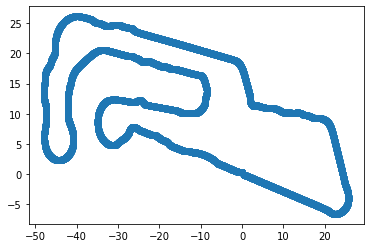

In [8]:
import matplotlib.pyplot as plt

plt.scatter(wps[:,0], wps[:, 1])

# environment

In [18]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from scipy.spatial.distance import cdist


class F110RaceEnv(gym.Env):
    def __init__(self, env_config,
                 test_map_name=None,
                 scan_range=10.0,
                 max_v=12.0,
                 n_cps = 100,
                 cp_reward = 0.1,
                 min_cp_dist=3.0,
                 maps_path='../maps',
                 models_path='../checkpoints',
                 train_map_name='Oschersleben',
                 safe_padding=0.3,
                 laps = 1.0,
                 min_deg=70,
                 max_deg=290,
                 begin_pos=[0.0702245, 0.3002981, 2.79787]
                ):
        
        self.laps = laps
        self.maps_path = maps_path
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(222,), dtype=np.float32)
        self.max_v = max_v
        self.test_map_name = test_map_name
        self.min_cp_dist = min_cp_dist
        self.n_cps = n_cps
        self.cp_reward = cp_reward
        self.scan_range = scan_range
        self.safe_padding = safe_padding
        self.map_path = None
        self.train_map_name = train_map_name
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.cum_r = 0
        self.prev_vel = [4.0] * 100
        self.total_padding_punish = 0
        self.min_deg = min_deg
        self.max_deg = max_deg
        self.begin_pos = begin_pos
    
    def _render_callback(self, env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800
  
    def load_train_setup(self):
        no = np.random.choice([1,])
        
        map_path = f"{self.maps_path}/{self.train_map_name}{no}"
        with open(f'{self.maps_path}/Oschersleben{no}-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps
    
    def load_test_setup(self):
        map_path = f"{self.maps_path}/{self.test_map_name}"
        with open(f'{self.maps_path}/Oschersleben1-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps

    def build_checkpoints(self, wps, cp_dist):
        
        start = np.random.randint(0, len(wps)-1)
        checkpoints = []
        
        i = 0
        while i < len(wps):
            if i % cp_dist == 0:
                checkpoints.append(wps[(start+i)%len(wps)])
            i += 1
        return checkpoints
    
    def reset(self):
        self.prev_vel = [3.0] * 100
        self.total_padding_punish = 0
        self.cum_r = 0
        
        if self.test_map_name is not None:
            map_path, wps = self.load_test_setup()
        else:
            map_path, wps = self.load_train_setup()
        
#         print(map_path, len(wps))
        self.map_path = map_path
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=1)
        self.env.add_render_callback(self._render_callback)
        
        cp_dist = len(wps)//self.n_cps
        
        self.checkpoints = self.build_checkpoints(wps, cp_dist)
#         print(f"number of checkpoints: {len(self.checkpoints)}")
        
        if self.test_map_name is None:
            start_idx = np.random.randint(0, len(self.checkpoints))
            start_point = self.checkpoints[start_idx]
            
        else:
            start_point = self.begin_pos
            
        self.next_cp_idx = (start_idx + 2)%len(self.checkpoints)
            
        
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point
            ])
        )
        
        self.t = 0

        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        ranges = obs['scans'][0]
        ranges = ranges[int((self.min_deg/360)*len(ranges)):int((self.max_deg/360)*len(ranges))]
        scanner = np.clip(ranges, 0, self.scan_range)
        
        buck = 3
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/self.max_v,
        ])
        
#         if self.test_map_name is None:
#             noise = np.random.normal(loc=0.0, scale=0.03, size=state.shape)
#             state = state + noise
        
        return state
    
    def checkpoint(self, position):
        return_cp_idx = (self.next_cp_idx - 5)%len(self.checkpoints)
        return_dist = np.linalg.norm(position - self.checkpoints[return_cp_idx][:2])
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        elif return_dist < 3.0:
            reward = -1
        return reward
        
        
    def step(self, action):
        reward = 0

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        self.prev_vel.insert(0, act_v)
        self.prev_vel.pop()
        
        
        th = action[1]*np.pi/6
        act = np.array([[th, act_v]])

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        next_state = self.to_vector_state(obs)
        position = np.array([pose_x, pose_y])

        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            if self.test_map_name is not None:
                print('CRASHED')
            return next_state, reward, done, {}
            
        cp_reward = self.checkpoint(position)
        reward += cp_reward
        self.t += 1
        
        if obs['lap_counts'][0] == self.laps:
            t = obs['lap_times'][0]  
#             reward = np.exp(2.5 - 0.05*t)
            fairlap = 50
            reward = max(0.2*(fairlap - t), self.cp_reward)
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. Finish reward: {reward}. Padding punish: {self.total_padding_punish}")
            done = True
        elif cp_reward == -1:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. RETURNED")
            done = True
        elif np.max(self.prev_vel)<3.0:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. STOPPED")
            reward = -1
            done = True
        
        if done and self.test_map_name is not None:
            print('lap:', obs['lap_times'])
        
        if np.min(obs['scans'][0]) < self.safe_padding:
            reward += -0.05
            self.total_padding_punish -= 0.05
        
        self.cum_r += reward
        return next_state, reward, done, {'pos': position}
    
    def render(self):
        self.env.render()

e = F110RaceEnv({})
e.reset()

array([0.10221464, 0.1022566 , 0.10285282, 0.10186481, 0.10260582,
       0.10420116, 0.10433218, 0.10307751, 0.10227701, 0.10304378,
       0.10408445, 0.10398413, 0.10254347, 0.10250877, 0.10233451,
       0.10118221, 0.10243289, 0.10585351, 0.10771922, 0.10838326,
       0.10819675, 0.10974692, 0.1119711 , 0.11000869, 0.10923566,
       0.11152929, 0.1152675 , 0.11553476, 0.11539386, 0.11563805,
       0.11690546, 0.11595188, 0.11827819, 0.11581901, 0.12152783,
       0.12329526, 0.12372556, 0.12421733, 0.12315667, 0.12534572,
       0.12472216, 0.12606257, 0.12567582, 0.13212945, 0.13377519,
       0.13330017, 0.13531156, 0.13693286, 0.135732  , 0.14116993,
       0.14440438, 0.14463825, 0.14611168, 0.14430886, 0.14936284,
       0.15120417, 0.15420592, 0.1567262 , 0.1590223 , 0.15872404,
       0.16644923, 0.16852212, 0.16976452, 0.17190581, 0.17313304,
       0.17947604, 0.17971073, 0.18441526, 0.19412427, 0.19346592,
       0.19879991, 0.20640736, 0.21013472, 0.21165295, 0.22098

# training

In [19]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [21]:
%%time

import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()



# with half cheeta configs

hc_configs = {
    'framework': 'torch',
    'num_workers': 15,
    'gamma': 0.99,
    'num_gpus': 1.0,
    'kl_coeff': 1.0,
    'clip_param': 0.2,
    'model': {
        'fcnet_hiddens': [300, 300],
    },
    'num_envs_per_worker': 1,
    'train_batch_size': 100000,
    'sgd_minibatch_size': 4096,
    'batch_mode': 'truncate_episodes',
    'lr': .0003,
}


trainer = ppo.PPOTrainer(env=F110RaceEnv, config=hc_configs)
# print("FINE TUNING")
# trainer.restore('../checkpoints/v2.2/checkpoint_000031/checkpoint-31')

print(trainer.config)
rewards = []
best_reward = -100
models_path = '../checkpoints'

import pickle

for i in range(50):
    result = trainer.train()
    episode_r = result['episode_reward_mean']
    print(f"episode: {i} reward:{episode_r}")
    rewards.append(episode_r)
    with open(f'{models_path}/sim_v1.0_r', 'wb') as f:
        pickle.dump(rewards, f)
        
    if i%5 == 0 and episode_r > best_reward:
        best_reward = episode_r
        cp = trainer.save(f"{models_path}/sim_v1.0")
        print("checkpoint saved at", cp)


2022-04-18 17:53:26,983	WARNING ppo.py:223 -- `train_batch_size` (100000) cannot be achieved with your other settings (num_workers=15 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 6666.
(RolloutWorker pid=16573) 2022-04-18 17:53:32,290	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=16566) 2022-04-18 17:53:33,539	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=16544) 2022-04-18 17:53:34,088	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will

{'num_workers': 15, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 6666, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.0003, 'train_batch_size': 100000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [300, 300], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_

episode: 0 reward:-1.1719263642340565
checkpoint saved at ../checkpoints/sim_v1.0/checkpoint_000001/checkpoint-1
episode: 1 reward:-1.1795053003533569
episode: 2 reward:-1.1710702341137122
episode: 3 reward:-1.1128877005347593
episode: 4 reward:-1.033904109589041
episode: 5 reward:-0.9301136363636364
checkpoint saved at ../checkpoints/sim_v1.0/checkpoint_000006/checkpoint-6
episode: 6 reward:-0.8021739130434783
episode: 7 reward:-0.6012857142857143
episode: 8 reward:-0.28110236220472434
episode: 9 reward:0.008208955223880881
episode: 10 reward:0.522955974842768
checkpoint saved at ../checkpoints/sim_v1.0/checkpoint_000011/checkpoint-11
episode: 11 reward:0.34077380952381026
episode: 12 reward:0.863157894736843
(RolloutWorker pid=16547) agent on ../maps/Oschersleben1 got reward 7.199999999999994 in 54.909999999997645. Finish reward: 0.1. Padding punish: -2.8999999999999977
(RolloutWorker pid=16573) agent on ../maps/Oschersleben1 got reward 7.3999999999999915 in 53.25999999999797. Finish

(RolloutWorker pid=16539) agent on ../maps/Oschersleben1 got reward 8.399999999999984 in 52.949999999998035. Finish reward: 0.1. Padding punish: -1.7000000000000008
(RolloutWorker pid=16552) agent on ../maps/Oschersleben1 got reward 7.299999999999991 in 54.17999999999779. Finish reward: 0.1. Padding punish: -2.799999999999998
(RolloutWorker pid=16556) agent on ../maps/Oschersleben1 got reward 8.19999999999999 in 52.949999999998035. Finish reward: 0.1. Padding punish: -1.900000000000001
(RolloutWorker pid=16544) agent on ../maps/Oschersleben1 got reward 8.499999999999986 in 50.91999999999844. Finish reward: 0.1. Padding punish: -1.6000000000000008
(RolloutWorker pid=16547) agent on ../maps/Oschersleben1 got reward 7.249999999999991 in 52.83999999999806. Finish reward: 0.1. Padding punish: -2.849999999999998
(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 8.449999999999987 in 51.85999999999825. Finish reward: 0.1. Padding punish: -1.6500000000000008
(RolloutWorker pid

(RolloutWorker pid=16551) agent on ../maps/Oschersleben1 got reward 8.449999999999989 in 49.85999999999865. Finish reward: 0.1. Padding punish: -1.6500000000000008
(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 9.099999999999978 in 49.89999999999864. Finish reward: 0.1. Padding punish: -1.0000000000000002
episode: 22 reward:3.817440000000029
(RolloutWorker pid=16571) agent on ../maps/Oschersleben1 got reward 8.649999999999986 in 48.90999999999884. Finish reward: 0.21800000000023234. Padding punish: -1.4500000000000006
(RolloutWorker pid=16547) agent on ../maps/Oschersleben1 got reward 9.899999999999983 in 49.01999999999882. Finish reward: 0.1960000000002367. Padding punish: -0.2
(RolloutWorker pid=16560) agent on ../maps/Oschersleben1 got reward 8.249999999999991 in 47.969999999999025. Finish reward: 0.4060000000001949. Padding punish: -1.850000000000001
(RolloutWorker pid=16561) agent on ../maps/Oschersleben1 got reward 8.649999999999988 in 49.18999999999878. Fini

(RolloutWorker pid=16552) agent on ../maps/Oschersleben1 got reward 7.799999999999988 in 48.219999999998976. Finish reward: 0.3560000000002049. Padding punish: -2.3
(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 9.399999999999984 in 47.669999999999085. Finish reward: 0.466000000000183. Padding punish: -0.7000000000000001
(RolloutWorker pid=16574) agent on ../maps/Oschersleben1 got reward 7.799999999999993 in 47.83999999999905. Finish reward: 0.4320000000001898. Padding punish: -2.3
(RolloutWorker pid=16560) agent on ../maps/Oschersleben1 got reward 9.049999999999985 in 47.48999999999912. Finish reward: 0.5020000000001759. Padding punish: -1.0500000000000003
(RolloutWorker pid=16566) agent on ../maps/Oschersleben1 got reward 9.599999999999982 in 46.84999999999925. Finish reward: 0.6300000000001504. Padding punish: -0.49999999999999994
episode: 24 reward:4.559440000000058
(RolloutWorker pid=16575) agent on ../maps/Oschersleben1 got reward 9.649999999999984 in 47.1499

(RolloutWorker pid=16574) agent on ../maps/Oschersleben1 got reward 8.349999999999985 in 48.14999999999899. Finish reward: 0.3700000000002021. Padding punish: -1.7500000000000009
(RolloutWorker pid=16566) agent on ../maps/Oschersleben1 got reward 7.549999999999996 in 47.73999999999907. Finish reward: 0.4520000000001858. Padding punish: -2.549999999999999
(RolloutWorker pid=16571) agent on ../maps/Oschersleben1 got reward 9.44999999999998 in 47.22999999999917. Finish reward: 0.5540000000001655. Padding punish: -0.65
(RolloutWorker pid=16547) agent on ../maps/Oschersleben1 got reward 8.799999999999985 in 47.669999999999085. Finish reward: 0.466000000000183. Padding punish: -1.2000000000000004
(RolloutWorker pid=16544) agent on ../maps/Oschersleben1 got reward 8.899999999999984 in 46.17999999999938. Finish reward: 0.7640000000001237. Padding punish: -1.2000000000000004
(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 8.899999999999986 in 47.42999999999913. Finish reward

(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 9.199999999999976 in 46.22999999999937. Finish reward: 0.7540000000001257. Padding punish: -0.9000000000000002
(RolloutWorker pid=16544) agent on ../maps/Oschersleben1 got reward 8.649999999999988 in 45.98999999999942. Finish reward: 0.8020000000001162. Padding punish: -1.4500000000000006
(RolloutWorker pid=16579) agent on ../maps/Oschersleben1 got reward 8.599999999999982 in 45.53999999999951. Finish reward: 0.8920000000000983. Padding punish: -1.5000000000000007
(RolloutWorker pid=16566) agent on ../maps/Oschersleben1 got reward 8.749999999999986 in 44.91999999999963. Finish reward: 1.0160000000000735. Padding punish: -1.3500000000000005
(RolloutWorker pid=16551) agent on ../maps/Oschersleben1 got reward 8.099999999999994 in 46.42999999999933. Finish reward: 0.7140000000001336. Padding punish: -2.000000000000001
(RolloutWorker pid=16571) agent on ../maps/Oschersleben1 got reward 9.699999999999974 in 44.27999999999976

(RolloutWorker pid=16556) agent on ../maps/Oschersleben1 got reward 8.999999999999979 in 45.99999999999942. Finish reward: 0.8000000000001166. Padding punish: -1.1000000000000003
(RolloutWorker pid=16539) agent on ../maps/Oschersleben1 got reward 8.849999999999982 in 45.49999999999952. Finish reward: 0.9000000000000967. Padding punish: -1.2500000000000004
(RolloutWorker pid=16571) agent on ../maps/Oschersleben1 got reward 9.449999999999983 in 46.14999999999939. Finish reward: 0.7700000000001226. Padding punish: -0.65
(RolloutWorker pid=16561) agent on ../maps/Oschersleben1 got reward 9.149999999999986 in 46.37999999999934. Finish reward: 0.7240000000001316. Padding punish: -0.9500000000000003
(RolloutWorker pid=16575) agent on ../maps/Oschersleben1 got reward 8.59999999999997 in 45.009999999999614. Finish reward: 0.9980000000000772. Padding punish: -1.4000000000000006
(RolloutWorker pid=16551) agent on ../maps/Oschersleben1 got reward 7.1499999999999915 in 46.67999999999928. Finish rew

(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 9.899999999999983 in 46.01999999999941. Finish reward: 0.7960000000001174. Padding punish: -0.2
(RolloutWorker pid=16547) agent on ../maps/Oschersleben1 got reward 9.049999999999985 in 46.11999999999939. Finish reward: 0.7760000000001214. Padding punish: -1.0500000000000003
(RolloutWorker pid=16560) agent on ../maps/Oschersleben1 got reward 8.899999999999983 in 45.78999999999946. Finish reward: 0.8420000000001082. Padding punish: -1.2000000000000004
(RolloutWorker pid=16544) agent on ../maps/Oschersleben1 got reward 8.049999999999988 in 45.68999999999948. Finish reward: 0.8620000000001042. Padding punish: -2.0500000000000007
(RolloutWorker pid=16579) agent on ../maps/Oschersleben1 got reward 8.849999999999962 in 45.23999999999957. Finish reward: 0.9520000000000863. Padding punish: -1.2500000000000004
(RolloutWorker pid=16566) agent on ../maps/Oschersleben1 got reward 9.099999999999978 in 45.209999999999575. Finish rewa

(RolloutWorker pid=16552) agent on ../maps/Oschersleben1 got reward 9.499999999999984 in 45.36999999999954. Finish reward: 0.9260000000000915. Padding punish: -0.6
(RolloutWorker pid=16556) agent on ../maps/Oschersleben1 got reward 9.449999999999978 in 45.67999999999948. Finish reward: 0.8640000000001038. Padding punish: -0.65
(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 9.849999999999982 in 46.669999999999284. Finish reward: 0.6660000000001433. Padding punish: -0.25
(RolloutWorker pid=16579) agent on ../maps/Oschersleben1 got reward 9.549999999999983 in 45.17999999999958. Finish reward: 0.9640000000000839. Padding punish: -0.5499999999999999
(RolloutWorker pid=16544) agent on ../maps/Oschersleben1 got reward 9.499999999999982 in 45.48999999999952. Finish reward: 0.9020000000000963. Padding punish: -0.6
(RolloutWorker pid=16573) agent on ../maps/Oschersleben1 got reward 9.949999999999982 in 45.64999999999949. Finish reward: 0.8700000000001027. Padding punish: -0.

(RolloutWorker pid=16566) agent on ../maps/Oschersleben1 got reward 8.749999999999986 in 45.92999999999943. Finish reward: 0.8140000000001137. Padding punish: -1.3500000000000005
(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 9.049999999999986 in 46.709999999999276. Finish reward: 0.6580000000001448. Padding punish: -1.0500000000000003
(RolloutWorker pid=16571) agent on ../maps/Oschersleben1 got reward 9.199999999999973 in 45.69999999999948. Finish reward: 0.8600000000001047. Padding punish: -0.9000000000000002
(RolloutWorker pid=16547) agent on ../maps/Oschersleben1 got reward 9.049999999999985 in 46.0899999999994. Finish reward: 0.7820000000001202. Padding punish: -1.0500000000000003
(RolloutWorker pid=16574) agent on ../maps/Oschersleben1 got reward 9.949999999999982 in 47.009999999999216. Finish reward: 0.5980000000001567. Padding punish: -0.15000000000000002
(RolloutWorker pid=16551) agent on ../maps/Oschersleben1 got reward 8.899999999999984 in 44.72999999999

(RolloutWorker pid=16574) agent on ../maps/Oschersleben1 got reward 8.74999999999999 in 43.399999999999935. Finish reward: 1.3200000000000132. Padding punish: -1.3500000000000005
(RolloutWorker pid=16561) agent on ../maps/Oschersleben1 got reward 8.249999999999988 in 44.42999999999973. Finish reward: 1.114000000000054. Padding punish: -1.850000000000001
(RolloutWorker pid=16579) agent on ../maps/Oschersleben1 got reward 9.499999999999984 in 44.97999999999962. Finish reward: 1.004000000000076. Padding punish: -0.6
(RolloutWorker pid=16547) agent on ../maps/Oschersleben1 got reward 9.199999999999985 in 45.009999999999614. Finish reward: 0.9980000000000772. Padding punish: -0.9000000000000002
(RolloutWorker pid=16573) agent on ../maps/Oschersleben1 got reward 7.649999999999989 in 44.249999999999766. Finish reward: 1.150000000000047. Padding punish: -2.4499999999999993
(RolloutWorker pid=16552) agent on ../maps/Oschersleben1 got reward 9.74999999999998 in 43.50999999999991. Finish reward: 

(RolloutWorker pid=16561) agent on ../maps/Oschersleben1 got reward 8.749999999999975 in 46.04999999999941. Finish reward: 0.7900000000001186. Padding punish: -1.3500000000000005
(RolloutWorker pid=16560) agent on ../maps/Oschersleben1 got reward 8.74999999999999 in 44.88999999999964. Finish reward: 1.0220000000000724. Padding punish: -1.3500000000000005
(RolloutWorker pid=16579) agent on ../maps/Oschersleben1 got reward 9.449999999999978 in 45.409999999999535. Finish reward: 0.9180000000000931. Padding punish: -0.65
(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 9.549999999999983 in 44.409999999999734. Finish reward: 1.1180000000000534. Padding punish: -0.5499999999999999
(RolloutWorker pid=16539) agent on ../maps/Oschersleben1 got reward 9.549999999999983 in 44.83999999999965. Finish reward: 1.0320000000000704. Padding punish: -0.5499999999999999
(RolloutWorker pid=16556) agent on ../maps/Oschersleben1 got reward 9.749999999999982 in 45.049999999999606. Finish re

(RolloutWorker pid=16574) agent on ../maps/Oschersleben1 got reward 9.699999999999982 in 43.46999999999992. Finish reward: 1.306000000000016. Padding punish: -0.39999999999999997
(RolloutWorker pid=16575) agent on ../maps/Oschersleben1 got reward 9.199999999999983 in 44.71999999999967. Finish reward: 1.0560000000000656. Padding punish: -0.9000000000000002
(RolloutWorker pid=16571) agent on ../maps/Oschersleben1 got reward 9.09999999999998 in 44.26999999999976. Finish reward: 1.1460000000000476. Padding punish: -1.0000000000000002
(RolloutWorker pid=16561) agent on ../maps/Oschersleben1 got reward 7.449999999999993 in 44.61999999999969. Finish reward: 1.0760000000000616. Padding punish: -2.6499999999999986
(RolloutWorker pid=16566) agent on ../maps/Oschersleben1 got reward 8.04999999999999 in 44.52999999999971. Finish reward: 1.094000000000058. Padding punish: -2.0500000000000007
(RolloutWorker pid=16551) agent on ../maps/Oschersleben1 got reward 8.849999999999984 in 44.17999999999978. 

(RolloutWorker pid=16552) agent on ../maps/Oschersleben1 got reward 9.499999999999984 in 43.70999999999987. Finish reward: 1.2580000000000255. Padding punish: -0.6
episode: 38 reward:7.641740000000012
(RolloutWorker pid=16566) agent on ../maps/Oschersleben1 got reward 9.799999999999981 in 42.950000000000024. Finish reward: 1.4099999999999953. Padding punish: -0.3
(RolloutWorker pid=16561) agent on ../maps/Oschersleben1 got reward 9.999999999999982 in 43.35999999999994. Finish reward: 1.3280000000000116. Padding punish: -0.1
(RolloutWorker pid=16551) agent on ../maps/Oschersleben1 got reward 9.39999999999998 in 43.37999999999994. Finish reward: 1.3240000000000123. Padding punish: -0.7000000000000001
(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 9.649999999999983 in 43.099999999999994. Finish reward: 1.3800000000000012. Padding punish: -0.44999999999999996
(RolloutWorker pid=16544) agent on ../maps/Oschersleben1 got reward 9.899999999999983 in 43.52999999999991. Fin

(RolloutWorker pid=16551) agent on ../maps/Oschersleben1 got reward 9.349999999999984 in 44.599999999999696. Finish reward: 1.080000000000061. Padding punish: -0.7500000000000001
(RolloutWorker pid=16547) agent on ../maps/Oschersleben1 got reward 9.449999999999983 in 44.01999999999981. Finish reward: 1.1960000000000377. Padding punish: -0.65
(RolloutWorker pid=16552) agent on ../maps/Oschersleben1 got reward 9.049999999999983 in 43.03000000000001. Finish reward: 1.3939999999999984. Padding punish: -1.0500000000000003
(RolloutWorker pid=16560) agent on ../maps/Oschersleben1 got reward 9.849999999999982 in 43.000000000000014. Finish reward: 1.3999999999999972. Padding punish: -0.25
(RolloutWorker pid=16575) agent on ../maps/Oschersleben1 got reward 9.549999999999983 in 43.67999999999988. Finish reward: 1.2640000000000242. Padding punish: -0.5499999999999999
(RolloutWorker pid=16544) agent on ../maps/Oschersleben1 got reward 10.049999999999981 in 42.66000000000008. Finish reward: 1.467999

(RolloutWorker pid=16566) agent on ../maps/Oschersleben1 got reward 8.849999999999987 in 43.35999999999994. Finish reward: 1.3280000000000116. Padding punish: -1.1500000000000004
(RolloutWorker pid=16561) agent on ../maps/Oschersleben1 got reward 9.49999999999998 in 43.86999999999984. Finish reward: 1.226000000000032. Padding punish: -0.6
(RolloutWorker pid=16573) agent on ../maps/Oschersleben1 got reward 9.749999999999982 in 43.71999999999987. Finish reward: 1.256000000000026. Padding punish: -0.35
(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 7.59999999999999 in 44.02999999999981. Finish reward: 1.1940000000000381. Padding punish: -2.499999999999999
(RolloutWorker pid=16579) agent on ../maps/Oschersleben1 got reward 7.949999999999989 in 43.46999999999992. Finish reward: 1.306000000000016. Padding punish: -2.1500000000000004
(RolloutWorker pid=16571) agent on ../maps/Oschersleben1 got reward 9.549999999999983 in 44.53999999999971. Finish reward: 1.092000000000058

(RolloutWorker pid=16579) agent on ../maps/Oschersleben1 got reward 9.69999999999998 in 42.5800000000001. Finish reward: 1.4839999999999804. Padding punish: -0.39999999999999997
(RolloutWorker pid=16552) agent on ../maps/Oschersleben1 got reward 9.54999999999998 in 42.81000000000005. Finish reward: 1.4379999999999897. Padding punish: -0.5499999999999999
(RolloutWorker pid=16560) agent on ../maps/Oschersleben1 got reward 9.449999999999985 in 43.43999999999993. Finish reward: 1.3120000000000147. Padding punish: -0.65
(RolloutWorker pid=16574) agent on ../maps/Oschersleben1 got reward 9.349999999999984 in 43.20999999999997. Finish reward: 1.3580000000000056. Padding punish: -0.7500000000000001
(RolloutWorker pid=16566) agent on ../maps/Oschersleben1 got reward 9.499999999999973 in 44.22999999999977. Finish reward: 1.154000000000046. Padding punish: -0.6
(RolloutWorker pid=16571) agent on ../maps/Oschersleben1 got reward 8.899999999999988 in 43.17999999999998. Finish reward: 1.364000000000

(RolloutWorker pid=16560) agent on ../maps/Oschersleben1 got reward 8.949999999999985 in 43.22999999999997. Finish reward: 1.3540000000000063. Padding punish: -1.0500000000000003
(RolloutWorker pid=16579) agent on ../maps/Oschersleben1 got reward 9.449999999999983 in 42.42000000000013. Finish reward: 1.5159999999999743. Padding punish: -0.65
(RolloutWorker pid=16566) agent on ../maps/Oschersleben1 got reward 9.549999999999983 in 43.41999999999993. Finish reward: 1.316000000000014. Padding punish: -0.5499999999999999
(RolloutWorker pid=16573) agent on ../maps/Oschersleben1 got reward 9.249999999999986 in 42.890000000000036. Finish reward: 1.4219999999999928. Padding punish: -0.8500000000000002
(RolloutWorker pid=16551) agent on ../maps/Oschersleben1 got reward 9.54999999999998 in 44.36999999999974. Finish reward: 1.1260000000000516. Padding punish: -0.5499999999999999
(RolloutWorker pid=16539) agent on ../maps/Oschersleben1 got reward 9.949999999999982 in 42.640000000000086. Finish rewa

(RolloutWorker pid=16551) agent on ../maps/Oschersleben1 got reward 9.599999999999978 in 44.51999999999971. Finish reward: 1.0960000000000576. Padding punish: -0.49999999999999994
(RolloutWorker pid=16539) agent on ../maps/Oschersleben1 got reward 8.099999999999989 in 44.27999999999976. Finish reward: 1.144000000000048. Padding punish: -2.000000000000001
(RolloutWorker pid=16574) agent on ../maps/Oschersleben1 got reward 9.199999999999987 in 43.03000000000001. Finish reward: 1.3939999999999984. Padding punish: -0.8000000000000002
(RolloutWorker pid=16579) agent on ../maps/Oschersleben1 got reward 8.749999999999986 in 42.940000000000026. Finish reward: 1.4119999999999948. Padding punish: -1.3500000000000005
(RolloutWorker pid=16556) agent on ../maps/Oschersleben1 got reward 8.29999999999998 in 43.07. Finish reward: 1.3860000000000001. Padding punish: -1.800000000000001
(RolloutWorker pid=16571) agent on ../maps/Oschersleben1 got reward 9.649999999999983 in 43.000000000000014. Finish rew

(RolloutWorker pid=16547) agent on ../maps/Oschersleben1 got reward 9.649999999999984 in 43.03000000000001. Finish reward: 1.3939999999999984. Padding punish: -0.44999999999999996
(RolloutWorker pid=16574) agent on ../maps/Oschersleben1 got reward 9.449999999999985 in 42.25000000000016. Finish reward: 1.5499999999999674. Padding punish: -0.65
(RolloutWorker pid=16552) agent on ../maps/Oschersleben1 got reward 9.549999999999978 in 42.0700000000002. Finish reward: 1.5859999999999603. Padding punish: -0.5499999999999999
episode: 45 reward:8.194999999999986
(RolloutWorker pid=16566) agent on ../maps/Oschersleben1 got reward 9.59999999999998 in 42.93000000000003. Finish reward: 1.4139999999999944. Padding punish: -0.49999999999999994
(RolloutWorker pid=16571) agent on ../maps/Oschersleben1 got reward 9.849999999999984 in 42.93000000000003. Finish reward: 1.4139999999999944. Padding punish: -0.25
(RolloutWorker pid=16551) agent on ../maps/Oschersleben1 got reward 8.099999999999987 in 43.2599

(RolloutWorker pid=16574) agent on ../maps/Oschersleben1 got reward 8.749999999999986 in 41.27000000000036. Finish reward: 1.7459999999999285. Padding punish: -1.3500000000000005
(RolloutWorker pid=16575) agent on ../maps/Oschersleben1 got reward 9.049999999999988 in 42.5800000000001. Finish reward: 1.4839999999999804. Padding punish: -1.0500000000000003
(RolloutWorker pid=16561) agent on ../maps/Oschersleben1 got reward 9.549999999999983 in 42.340000000000146. Finish reward: 1.531999999999971. Padding punish: -0.5499999999999999
(RolloutWorker pid=16579) agent on ../maps/Oschersleben1 got reward 8.399999999999988 in 41.5800000000003. Finish reward: 1.6839999999999407. Padding punish: -1.7000000000000008
(RolloutWorker pid=16573) agent on ../maps/Oschersleben1 got reward 7.849999999999992 in 42.750000000000064. Finish reward: 1.4499999999999873. Padding punish: -2.25
(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 9.149999999999983 in 42.41000000000013. Finish rewar

(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 9.899999999999977 in 42.28000000000016. Finish reward: 1.5439999999999685. Padding punish: -0.2
(RolloutWorker pid=16579) agent on ../maps/Oschersleben1 got reward 9.599999999999984 in 41.840000000000245. Finish reward: 1.631999999999951. Padding punish: -0.49999999999999994
(RolloutWorker pid=16547) agent on ../maps/Oschersleben1 got reward 9.349999999999984 in 42.11000000000019. Finish reward: 1.5779999999999619. Padding punish: -0.7500000000000001
(RolloutWorker pid=16556) agent on ../maps/Oschersleben1 got reward 9.099999999999985 in 42.46000000000012. Finish reward: 1.5079999999999758. Padding punish: -1.0000000000000002
(RolloutWorker pid=16552) agent on ../maps/Oschersleben1 got reward 8.549999999999988 in 41.68000000000028. Finish reward: 1.6639999999999446. Padding punish: -1.5500000000000007
(RolloutWorker pid=16539) agent on ../maps/Oschersleben1 got reward 8.949999999999989 in 41.78000000000026. Finish rewa

(RolloutWorker pid=16556) agent on ../maps/Oschersleben1 got reward 9.899999999999983 in 41.93000000000023. Finish reward: 1.6139999999999546. Padding punish: -0.2
(RolloutWorker pid=16544) agent on ../maps/Oschersleben1 got reward 9.599999999999982 in 41.0500000000004. Finish reward: 1.7899999999999197. Padding punish: -0.49999999999999994
(RolloutWorker pid=16560) agent on ../maps/Oschersleben1 got reward 8.149999999999993 in 41.01000000000041. Finish reward: 1.797999999999918. Padding punish: -1.950000000000001
(RolloutWorker pid=16557) agent on ../maps/Oschersleben1 got reward 9.999999999999982 in 41.95000000000022. Finish reward: 1.6099999999999555. Padding punish: -0.1
(RolloutWorker pid=16571) agent on ../maps/Oschersleben1 got reward 8.699999999999987 in 41.740000000000265. Finish reward: 1.651999999999947. Padding punish: -1.4000000000000006
(RolloutWorker pid=16574) agent on ../maps/Oschersleben1 got reward 9.799999999999976 in 40.97000000000042. Finish reward: 1.805999999999

## evaluation

In [3]:
import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [300, 300]
DEFAULT_CONFIG["evaluation_num_workers"] = 0
DEFAULT_CONFIG["evaluation_config"]["render_env"] = False
DEFAULT_CONFIG["evaluation_config"]["explore"] = False
DEFAULT_CONFIG['explore'] = False

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=DEFAULT_CONFIG)
trainer.restore('../checkpoints/sim_v2.0/checkpoint_000071/checkpoint-71')



Install gputil for GPU system monitoring.
2022-04-18 13:21:05,234	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/sim_v2.0/checkpoint_000071/checkpoint-71
2022-04-18 13:21:05,235	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 71, '_timesteps_total': 14198580, '_time_total': 2876.4855439662933, '_episodes_total': 8496}


In [9]:
done = False
env = F110RaceEnv({}, test_map_name='SILVERSTONE_TRAIN3', laps=2)
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, info = env.step(action)
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    
print(f'reward:{r}')
env.close()

# hist

agent on ../maps/SILVERSTONE_TRAIN3 got reward 7.649999999999989 in 19.090000000000185. STOPPED
lap: [19.09]
reward:6.649999999999989


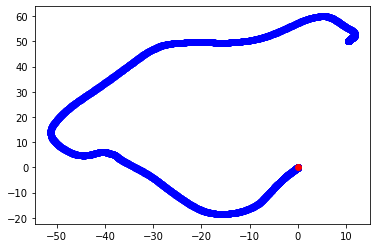

In [5]:
import matplotlib.pyplot as plt

wps = np.array([i[-1] for i in hist])
plt.scatter(wps[:,0], wps[:,1], c='b')
plt.scatter(wps[0,0], wps[0,1], c='r')

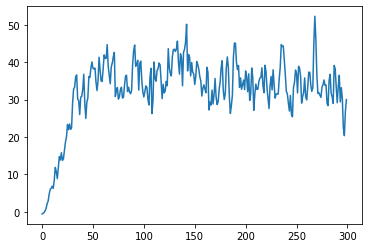

In [44]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/race_v1.1_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

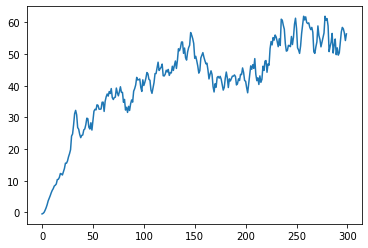

In [4]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/v1.2_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

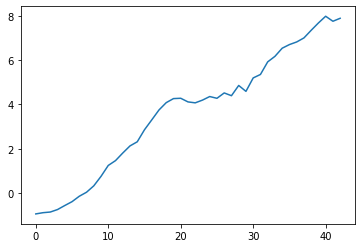

In [5]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/v2.3_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)
